### Instrukcje
Załóżmy, że chcemy kupić mieszkanie. Do dyspozycji mamy 100 000 dolarów, możemy też wziąć kredyt na kolejne 250 tysięcy, co da nam w sumie budżet w wysokości 350 000 dolarów. Stwórzmy model który pomoże nam przewidzieć, czy mieszkanie o pewnych, zadanych parametrach, możemy kupić za własne pieniądze (cheap), z kredytem (average), czy jest poza naszym zasięgiem (expensive).

W oparciu o dostępne atrybuty zbuduj model, który pomoże oszacować, czy dana nieruchomość należy do klasy cheap, average czy expensive. Do dyspozycji mają Państwo dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz, tak jak ostatnio, zbiór testowy (test_data.csv).

UWAGA Proszę dokładnie zastosować się do poniższej instrukcji
W ramach rozwiązania, proszę oddać poprzez Teamsy plik - archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze test_data.csv.
W pliku z predykcjami powinna się znajdować dokładnie jedna kolumna, oznaczająca przewidywaną przez Państwa klasę ceny mieszkania (0 <- cheap, 1 <- average, 2 <- expensive).
Końcowe wyniki obliczał będę w oparciu o średnią dokładność dla każdej klasy. Proszę zwrócić uwagę na fakt, że klasy są mocno niezbalansowane!
Koniecznie proszę sprawdzić format zwracanych przez Państwa predykcji (tyle predykcji ile elementów w zbiorze testowym, brak nagłówków, jedna kolumna, itd.)
Bardzo proszę nazywać wszystkie pliki nazwiskami autorów (najlepiej alfabetycznie), lub nazwą zespołu. Nazwę głównego archiwum zip proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_ (nie pon/pia), proszę też nie umieszczać plików w dodatkowych podfolderach tylko bezpośrednio .
W MS ​Teams wszystkim przydzieliłem zadanie, ale bardzo proszę, żeby tylko jeden (dowolny) członek zespołu je zwrócił.
W razie pytań zapraszam do korespondencji lub na konsultacje.

In [330]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

## Read data

In [331]:
train = pd.read_csv("data/train_data.csv")
test = pd.read_csv("data/test_data.csv")

## Preprocess data

1. Recognize missing data
2. Feature engineering
3. Encode SalePrice into 3 classes
4. Identify numerical and categorical columns
5. Standardize numerical columns
6. Encode categorical data

## Missing data

In [332]:
train.isna().all(axis=0).any()

False

In [333]:
test.isna().all(axis=0).any()

False

## Feature engineering

#### 1. Use YearBuilt to engineer new features.

- __Age of the apartment.__
Since there is no information when this data was collected, use the earliest value of YearBuilt as a reference for others.

<Axes: xlabel='ApartmentAge', ylabel='Count'>

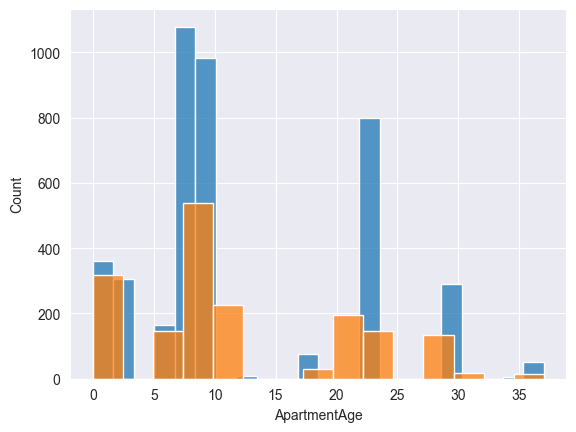

In [334]:
train['ApartmentAge'] = train.YearBuilt.max() - train.YearBuilt
sns.histplot(train['ApartmentAge'])

test['ApartmentAge'] = test.YearBuilt.max() - test.YearBuilt
sns.histplot(test['ApartmentAge'])

## Encode SalePrice into 3 classes

In [335]:
def encode_sale_price(df):
    label_encoded = np.select(condlist=[
        df.SalePrice <= 100000,
        (df.SalePrice > 100000) & (df.SalePrice <= 350000),
        df.SalePrice > 350000,
    ], choicelist=[0, 1, 2])
    return pd.get_dummies(label_encoded)

In [336]:
train_target = encode_sale_price(train)
train.drop(columns=["SalePrice"], inplace=True)

In [337]:
train_target.iloc[:5, :]

,0,1,2
0,0,1,0
1,1,0,0
2,1,0,0
3,0,0,1
4,1,0,0


## Identify numerical and categorical columns

In [338]:
categorical_cols = list(train.select_dtypes(include=['object', 'category']).columns)
categorical_cols

['HallwayType',
 'HeatingType',
 'AptManageType',
 'TimeToBusStop',
 'TimeToSubway',
 'SubwayStation']

In [339]:
train.dtypes

YearBuilt                      int64
Size(sqf)                      int64
Floor                          int64
HallwayType                   object
HeatingType                   object
AptManageType                 object
N_Parkinglot(Ground)         float64
N_Parkinglot(Basement)       float64
TimeToBusStop                 object
TimeToSubway                  object
N_manager                    float64
N_elevators                  float64
SubwayStation                 object
N_FacilitiesInApt              int64
N_FacilitiesNearBy(Total)    float64
N_SchoolNearBy(Total)        float64
ApartmentAge                   int64
dtype: object

????? Add __Floor__ to categorical columns

In [340]:
# ????? REMOVE
# categorical_cols += ["Floor"]
# train.Floor = train.Floor.astype("object")
# categorical_cols

In [341]:
train_categorical_data = pd.get_dummies(train[categorical_cols])
test_categorical_data = pd.get_dummies(test[categorical_cols])

In [342]:
train_categorical_data.head()

,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating,AptManageType_management_in_trust,AptManageType_self_management,TimeToBusStop_0~5min,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


# Standardize numerical columns

In [343]:
from sklearn.preprocessing import StandardScaler

In [344]:
numerical_columns = set(train.columns) - set(categorical_cols); print(numerical_columns)
train_numerical_data = train[list(numerical_columns)]
test_numerical_data = test[list(numerical_columns)]
train_numerical_data.head()

{'N_FacilitiesNearBy(Total)', 'N_FacilitiesInApt', 'N_SchoolNearBy(Total)', 'N_manager', 'ApartmentAge', 'N_Parkinglot(Ground)', 'Floor', 'Size(sqf)', 'YearBuilt', 'N_elevators', 'N_Parkinglot(Basement)'}


,N_FacilitiesNearBy(Total),N_FacilitiesInApt,N_SchoolNearBy(Total),N_manager,ApartmentAge,N_Parkinglot(Ground),Floor,Size(sqf),YearBuilt,N_elevators,N_Parkinglot(Basement)
0,6.0,5,9.0,3.0,9,111.0,3,814,2006,0.0,184.0
1,12.0,3,4.0,2.0,30,80.0,8,587,1985,2.0,76.0
2,12.0,3,4.0,2.0,30,80.0,6,587,1985,2.0,76.0
3,3.0,5,7.0,5.0,9,249.0,8,2056,2006,11.0,536.0
4,9.0,3,14.0,4.0,23,142.0,2,644,1992,8.0,79.0


In [345]:
scaler = StandardScaler()
train_numerical_data = pd.DataFrame(scaler.fit_transform(train_numerical_data), columns=train_numerical_data.columns)
test_numerical_data = pd.DataFrame(scaler.transform(test_numerical_data), columns=test_numerical_data.columns)

## Datasets

In [346]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

import torch.utils.data as data
from sklearn.model_selection import train_test_split

In [347]:
train_indices = train.sample(frac=0.8, random_state=121).index

In [348]:
train_numerical_data_torch = torch.from_numpy(train_numerical_data.values[train_indices,:]).float()
train_categorical_data_torch = torch.from_numpy(train_categorical_data.values[train_indices, :]).float()
train_targets_torch = torch.from_numpy(train_target.values[train_indices]).float()

test_numerical_data_torch = torch.from_numpy(train_numerical_data.values[~train_indices,:]).float()
test_categorical_data_torch = torch.from_numpy(train_categorical_data.values[~train_indices,:]).float()
test_targets_torch = torch.from_numpy(train_target.values[~train_indices]).float()

train_dataset = data.TensorDataset(train_numerical_data_torch, train_categorical_data_torch, train_targets_torch)
test_dataset = data.TensorDataset(test_numerical_data_torch, test_categorical_data_torch, test_targets_torch)

In [350]:
train_dataset, test_dataset

(<torch.utils.data.dataset.TensorDataset at 0x15ec5572ac0>,
 <torch.utils.data.dataset.TensorDataset at 0x15ec568e550>)